In [1]:
import json

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

In [2]:
import numpy as np
np.random.seed(10)

In [3]:
from nltk.corpus import stopwords

In [4]:
import tensorflow as tf

/home/arjun/venvs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import keras

Using TensorFlow backend.


In [6]:
train = pd.read_csv('../data/train.csv')

In [7]:
train.dropna(subset=['question1', 'question2', 'is_duplicate'], inplace=True)

## Vanilla Approach

In [35]:
train_pos = train[train['is_duplicate'] == 1]
train_neg = train[train['is_duplicate'] == 0]
print('Number of positive example:', len(train_pos))
print('Number of negative example:', len(train_neg))

Number of positive example: 149263
Number of negative example: 255024


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_trainq1, X_validq1, X_trainq2, X_validq2, y_train, y_valid = train_test_split(train['question1'], train['question2'], train['is_duplicate'], test_size=0.1, random_state=1)

In [10]:
print('Train size:', len(y_train))
print('Test size:', len(y_valid))

Train size: 363858
Test size: 40429


In [11]:
from keras.preprocessing.text import Tokenizer

In [12]:
t = Tokenizer(num_words=25000)

In [13]:
t.fit_on_texts(X_trainq1.tolist() + X_trainq2.tolist())

In [14]:
len(t.word_index)

91134

In [73]:
word_cnt = t.word_counts.values()

In [74]:
np.count_nonzero(np.array(list(word_cnt)) > 5)

26841

/home/arjun/venvs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Probability')

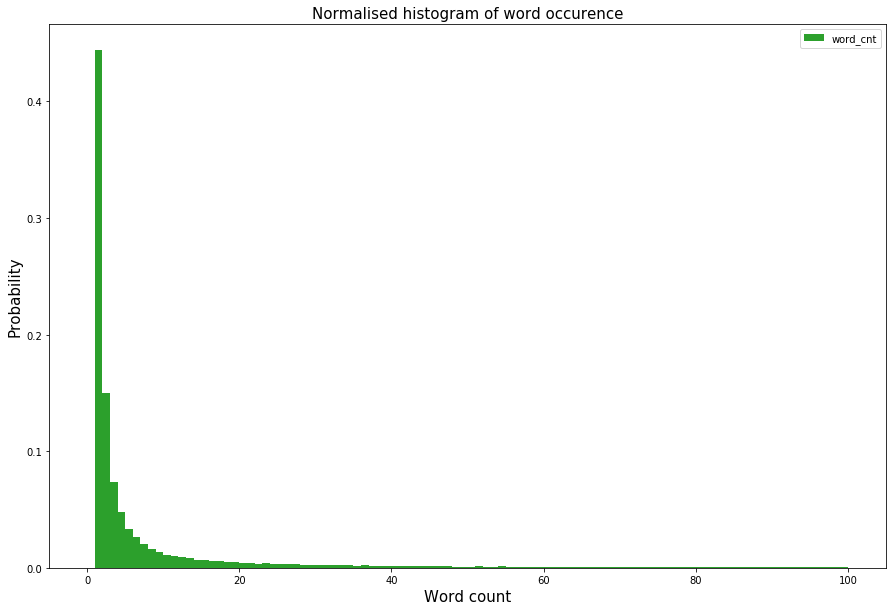

In [75]:
plt.figure(figsize=(15, 10))
plt.hist(word_cnt, bins=100, range=[0, 100], color=pal[2], normed=True, label='word_cnt')
plt.title('Normalised histogram of word occurence', fontsize=15)
plt.legend()
plt.xlabel('Word count', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### Prep training data

In [15]:
X_trainq1_vec = t.texts_to_sequences(X_trainq1)
X_trainq2_vec = t.texts_to_sequences(X_trainq2)

In [16]:
from keras.preprocessing import sequence

In [17]:
X_trainq1_vec = sequence.pad_sequences(X_trainq1_vec, maxlen=50)
X_trainq2_vec = sequence.pad_sequences(X_trainq2_vec, maxlen=50)

In [18]:
print('Train Q1 shape:', X_trainq1_vec.shape)
print('Train Q2 shape:', X_trainq2_vec.shape)
print('Train Label shape:', y_train.shape)

Train Q1 shape: (363858, 50)
Train Q2 shape: (363858, 50)
Train Label shape: (363858,)


### Prep validation data

In [19]:
X_validq1_vec = t.texts_to_sequences(X_validq1)
X_validq2_vec = t.texts_to_sequences(X_validq2)

In [20]:
X_validq1_vec = sequence.pad_sequences(X_validq1_vec, maxlen=50)
X_validq2_vec = sequence.pad_sequences(X_validq2_vec, maxlen=50)

In [21]:
print('valid Q1 shape:', X_validq1_vec.shape)
print('valid Q2 shape:', X_validq2_vec.shape)
print('valid Label shape:', y_valid.shape)

valid Q1 shape: (40429, 50)
valid Q2 shape: (40429, 50)
valid Label shape: (40429,)


# NN

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense, Merge, Input
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
# fix random seed for reproducibility
# np.random.seed(7)

from keras.callbacks import TensorBoard

In [33]:
max_sentence_len = 50
embedding_dim = 128

In [32]:
q1_input = Input(shape=(max_sentence_len,), dtype='int32', name='q1_input')
q2_input = Input(shape=(max_sentence_len,), dtype='int32', name='q2_input')

In [34]:
embed = Embedding(input_dim=25000, output_dim=embedding_dim, input_length=max_sentence_len)
embed_q1 = embed(q1_input)
embed_q2 = embed(q2_input)

In [35]:
shared_lstm = LSTM(256)

In [36]:
encoded_q1 = shared_lstm(embed_q1)
encoded_q2 = shared_lstm(embed_q2)

In [43]:
x = keras.layers.dot([encoded_q1, encoded_q2], axes=-1)
# output = keras.layers.activations.sigmoid(x)
output = Dense(1, activation='sigmoid')(x)

In [44]:
model = Model(inputs=[q1_input, q2_input], outputs=output)

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'q1_input:0' shape=(?, 50) dtype=int32>, <tf.Tensor 'q2_input:0' shape=(?, 50) dtype=int32>]
[<tf.Tensor 'dense_2/Sigmoid:0' shape=(?, 1) dtype=float32>]


In [50]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_input (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
q2_input (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      3200000     q1_input[0][0]                   
                                                                 q2_input[0][0]                   
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256)          394240      embedding_2[0][0]                
          

In [52]:
import time

In [53]:
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time.strftime('%Y-%m-%dT%H-%M-%S', time.localtime())))

In [55]:
model.fit([X_trainq1_vec, X_trainq2_vec], y_train, validation_data=([X_validq1_vec, X_validq2_vec], y_valid), epochs=30, batch_size=1024, callbacks=[tensorboard])

Train on 363858 samples, validate on 40429 samples
Epoch 1/30
363858/363858 [==============================] - 46s 127us/step - loss: 0.4717 - acc: 0.7782 - val_loss: 0.5418 - val_acc: 0.7598
Epoch 2/30
363858/363858 [==============================] - 46s 127us/step - loss: 0.4469 - acc: 0.7892 - val_loss: 0.5423 - val_acc: 0.7646
Epoch 3/30
363858/363858 [==============================] - 46s 127us/step - loss: 0.4248 - acc: 0.7980 - val_loss: 0.5849 - val_acc: 0.7676
Epoch 4/30
363858/363858 [==============================] - 46s 127us/step - loss: 0.4047 - acc: 0.8068 - val_loss: 0.5885 - val_acc: 0.7607
Epoch 5/30
363858/363858 [==============================] - 46s 127us/step - loss: 0.3855 - acc: 0.8162 - val_loss: 0.6068 - val_acc: 0.7528
Epoch 6/30
363858/363858 [==============================] - 46s 127us/step - loss: 0.3683 - acc: 0.8239 - val_loss: 0.6433 - val_acc: 0.7602
Epoch 7/30
363858/363858 [==============================] - 46s 127us/step - loss: 0.3506 - acc: 0.8328

KeyboardInterrupt: 